In [117]:
import sys
!{sys.executable} -m pip install pyreadr seaborn sklearn

In [161]:
import pickle
import pyreadr
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import scipy.stats as ss
import seaborn as sns
sns.set()
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
title_fontsize = 20
xlabel_fontsize = 18
ylabel_fontsize = 18
legend_fontsize = 14
ticks_fontsize = 18
figure_format = "pdf"
%matplotlib inline
runmode = "test" # "prod", or other such as "test", or "beta", or something else
# changes the behavior of the code

In [119]:
# # below blocks are a poor attempt to recreate the necessary .pkl files for the load_data function later
# import gzip
# tpm_path= "./GTEx_V8_RawData/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz"
# f = gzip.open(tpm_path, 'rt')
# file_content = f.read()

In [120]:
# # f1 = open("GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct", "w")
# # f1.write(file_content)
# # f1.close()

# # from cmapPy.pandasGEXpress.parse_gct import parse
# # tpm_data = parse(file_content)

# # from io import StringIO

# # s = str(file_content,'utf-8')
# # data = StringIO(s) 

# # much too slow
# tpm_data = pd.read_csv(data, delimiter='\t', skiprows=2)
# print(list(tpm_data.columns))

## Load metadata for samples and subjects in GTEx

In [121]:
# load sample metadata: 18220 samples, 73 technnical parameters
sampleMetaData = pd.read_csv('./GTEx_V8_RawData/GTEx_Analysis_2017-06-05_v8_Annotations_SampleAttributesDS.txt', sep = '\t', header = 'infer', index_col=0)
# load sample metadata: 948 people, 174 phenotipic parameters
subjectMetaData = pd.read_csv('./GTEx_V8_RawData/GTEx_Analysis_2017-06-05_v8_Annotations_SubjectPhenotypesDS.txt', sep = '\t', header = 'infer', index_col=0)

print(sampleMetaData.describe())
print(subjectMetaData.describe())

c:\tools\anaconda3\envs\py38\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


           SMATSSCR         SMRIN      SMTSISCH       SMTSPAX  SMTORMVE  \
count  13828.000000  17382.000000  18153.000000  13805.000000       0.0   
mean       0.894996      7.275108    573.664518    845.796378       NaN   
std        0.601313      1.049560    400.418068    295.174741       NaN   
min        0.000000      3.200000  -1287.000000    240.000000       NaN   
25%        1.000000      6.500000    226.000000    590.000000       NaN   
50%        1.000000      7.200000    531.000000    836.000000       NaN   
75%        1.000000      7.900000    872.000000   1076.000000       NaN   
max        3.000000     10.000000   2076.000000   1673.000000       NaN   

       SMFLGRMRK  SMGTC      SME2MPRT      SMCHMPRS      SMNTRART  ...  \
count        0.0    0.0  17382.000000  1.738200e+04  17382.000000  ...   
mean         NaN    NaN      0.977538  3.965408e+05      0.968464  ...   
std          NaN    NaN      0.058277  3.263028e+05      0.013258  ...   
min          NaN    NaN     

## Load data by tissue

In [122]:
def load_data(tissue):
    """ Load gene expression for each tissue.
    
     Parameters
    ----------
    tissue: one of GTEx tissues
    
     Outputs
    ----------
    data : pd.DataFrame
        genes x samples dataframe
    age : np.array, int
        age of each subject who provided the sample for the tissue
    SMRIN : np.array, float
        RIN number (RNA integrity number) for each sample
    SMTSISCH : np.array, int
        total ischemic time for each sample
    """
    
    print(tissue)
    data_p_file = "./GTEx_V8_RNASeq_subTissueTypes/Expr_by_tissue/Expr_by_tissue/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm_"+\
    str(tissue)+".pkl"
    data = pd.read_pickle(data_p_file)
# TODO AAYUSH
#     # replace with RData ??
#     data_p_file = "./GTEx_V8_RNASeq_subTissueTypes/GTEx_" + str(tissue) + ".RData"
#     data = pyreadr.read_r(data_p_file)
#     print(data.keys())
#     for key in data.keys():
#         print(data[key])
    
    gene_ids = data['Name']
    gene_names = data['Description']
    data.index = gene_ids
    data = data.iloc[:,2:]
    print(data.shape[1], " samples, ", data.shape[0], "genes")
    
    # filter out genes that are expressed in fewer than 10% of samples
    data = data[(data.T == 0).sum()<0.1*data.shape[1]]
    print(str(len((data.T == 0).sum()>0.1*data.shape[1])) + " genes filtered out")
    
    # filter out samples that express fewer than 10% of genes
    data = data.loc[:,data.columns[(pd.isna(data)).sum()<0.1*data.shape[0]]]
    print(str(len(data.columns[(pd.isna(data)).sum()>0.1*data.shape[0]])) + " samples filtered out")
    
    # load age, SNRIN, and SMTSUSCH values for each subject
    subject_ids = [subject_id.split("-")[0]+"-"+subject_id.split("-")[1] for subject_id in \
     data.columns.tolist()]
    age = [np.asarray(subjectMetaData.loc[subjectMetaData.index==subject_id,'AGE'])[0] \
                   for subject_id in subject_ids]
    SMRIN = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMRIN'])[0] \
                   for sample_id in data.columns.tolist()]
    SMTSISCH = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMTSISCH'])[0] \
                   for sample_id in data.columns.tolist()]
    return data, age, SMRIN, SMTSISCH

## Load and filter data

Choosing tissues that have > 800 samples (8 tissues in GTEx). It is arbitrary, so you can choose a lower threshold to study more tissues if your age prediciton model works even for fewer samples

In [162]:
if(runmode == "prod"):
    tissues = ['Muscle',
    'Blood Vessel',
    'Brain',
    'Blood',
    'Skin',
    'Esophagus',
    'Heart',
    'Adipose Tissue']
else:
    tissues = ['Muscle', 'Blood Vessel']
    # tissues = ['Muscle_Skeletal'] # Left over from sub tissue types 

In [124]:
data = {}
age = {}
SMRIN = {}
SMTSISCH = {}

for tissue in tissues:
    data[tissue], age[tissue], SMRIN[tissue], SMTSISCH[tissue] = load_data(tissue)

Muscle
804  samples,  56200 genes
19544 genes filtered out
0 samples filtered out
Blood Vessel
1335  samples,  56200 genes
21218 genes filtered out
0 samples filtered out


## Correct for covariates and remove outliers

### Find genes with weak correlation with age

In [125]:
def define_non_age_related_genes(data, age):
    rhos = np.zeros((len(data.index.tolist())))
    spear_pvals = np.zeros((len(data.index.tolist())))
    for i, gene in enumerate(data.index.tolist()):
        rhos[i], spear_pvals[i] = ss.spearmanr(data.loc[gene,:], age, nan_policy = 'omit')
    gene_idxs = range(data.shape[0])
    gene_idxs = [gene_idx for gene_idx in gene_idxs if spear_pvals[gene_idx]>0.01]
    print(str(len(gene_idxs)) + " genes with no correlation with age")
    non_aging_expr = data.iloc[gene_idxs,:]
    return(non_aging_expr)

### Perform SVD (singular value decomposition) of non-age related gene expression

In [126]:
def svd(non_aging_expr, n_comp = 50):
    u, s, vh  = np.linalg.svd(non_aging_expr.transpose())
    d2 = s**2
    print("first " + str(n_comp) + " components explain " + str(d2[:n_comp].sum()/d2.sum()) + " variability")
    print(u.shape)
    u_top_10 = u[:n_comp,:]
    x_0 = u_top_10*s
    return(x_0)

### Regress out non-age-related covariates

In [127]:
import sklearn.linear_model as linear_model
def linear_regression(x_train, y_train):
    ols = linear_model.LinearRegression()
    model = ols.fit(x_train, y_train)
    return ols.coef_, ols.intercept_, ols.predict(x_train)

def regress_covariates(data, x_0):
    coeffs, intercepts, prediction = linear_regression(x_0.transpose(), data.transpose()) 
    residual = (data.transpose()-np.asmatrix(x_0.transpose())*coeffs.transpose()).transpose()
    return residual

### Exclude non-age-related genes

In [128]:
def exclude_non_age_related_genes(residual, gene_idxs):
    aging_gene_idxs = [i for i in range(len(residual.index)) if i not in gene_idxs]
    residual_aging = residual.iloc[aging_gene_idxs,:]
    return(residual_aging)

### Remove outliers

In [129]:
def plot_PCA(X, ax, tissue):
    for i in range(len(X[:, 0])):
        ax.scatter(X[i, 0], X[i, 1], color = 'C0')
    ax.set_title(tissue, fontsize = title_fontsize)
    ax.set_xlabel('PC1', fontsize = xlabel_fontsize)
    ax.set_xlabel('PC2', fontsize = ylabel_fontsize)

In [130]:
from sklearn import decomposition
def detect_outliers(residual_aging, tissue):
    pca = decomposition.PCA(n_components=2)
    X = residual_aging.transpose().copy()
    pca.fit(X)
    X = pca.transform(X)
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    plot_PCA(X, ax, tissue)
    q1 = pd.DataFrame(X[:, 0]).quantile(0.999)
    q2 = pd.DataFrame(X[:, 1]).quantile(0.999)
    print(q1[0])
    print(q2[0])
    residual_no_outliers = residual_aging.iloc[:,np.asarray([j for j in \
                                                             range(len(residual_aging.columns)) \
                                                             if X[j, 0] < q1[0] and X[j, 1] < q2[0]])]
    print(str(residual_aging.shape[0] - residual_no_outliers.shape[0]) + " outliers removed")
    
    subj_ids = [subject_id.split("-")[0]+"-"+subject_id.split("-")[1] for subject_id in \
                residual_no_outliers.columns.tolist()]
    ages = [np.asarray(subjectMetaData.loc[subjectMetaData.index==subject_id,'AGE'])[0] \
                   for subject_id in subj_ids]
    SMRINs = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMRIN'])[0] \
                   for sample_id in residual_no_outliers.columns.tolist()]
    SMTSISCHs = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMTSISCH'])[0] \
                   for sample_id in residual_no_outliers.columns.tolist()]
    return residual_no_outliers, ages, SMRINs, SMTSISCHs

In [131]:
non_aging_expr = {}
x_0 = {}
residual = {}
residual_aging = {}
residual_no_outliers = {}
ages = {}
SMRINs = {}
SMTSISCHs = {}
should_filter = False

if(should_filter):
        for i, tissue in enumerate(tissues):
                print(tissue)
                
                non_aging_expr[tissue] = define_non_age_related_genes(data[tissue], age[tissue])
                x_0[tissue] = svd(non_aging_expr[tissue], n_comp=50)
                residual[tissue] = regress_covariates(data[tissue], x_0[tissue])
                residual_aging[tissue] = exclude_non_age_related_genes(residual[tissue], \
                                                                non_aging_expr[tissue].index.tolist())
                residual_no_outliers[tissue], ages[tissue], SMRINs[tissue], SMTSISCHs[tissue] = \
                detect_outliers(residual_aging[tissue], tissue)

## Build the model predicting age with Lasso

In [132]:
def split_train_valid_test(num_examples,training_proportion,validation_proportion,test_proportion):
    assert training_proportion<=1.0
    assert validation_proportion<=1.0
    assert test_proportion<=1.0
    assert (training_proportion+validation_proportion+test_proportion)<=1.0

    idx_shuff=np.random.RandomState(seed=77).permutation(range(num_examples))

    training_threshold=int(num_examples*training_proportion)
    validation_threshold=int(num_examples*(training_proportion+validation_proportion))

    training=range(training_threshold)
    validation=range(training_threshold,min(validation_threshold,num_examples))
    test=range(validation_threshold,num_examples)

    return(idx_shuff[list(training)],idx_shuff[list(validation)],idx_shuff[list(test)])

In [133]:
def fit_lasso_model(residual_no_outliers, ages, tol):
    """ Build an age predictor with the lasso model and estimate its performance.
    
     Parameters
    ----------
    residual_no_outliers: pd.DataFrame
        gene expression for a tissue after all preprocessing: \
        - QC of genes and samples
        - regression of technical and phenotipic covariates explaining most of the variability \
            (except age, we need this variability, so we don't regress it out)
        - removal of outliers
    ages : np.array, int
        ages of samples in a tissue gene expression matrix
    tol : float, default=1e-4
        tolerance for the optimization in the lasso model
        
     Outputs
    ----------
    genes : np.array, str
        genes that are predictive of the age according to the lasso model
    score : float
        coefficient of determination R^2 of the prediction
    pearsonr : float
        Pearson's correlation coefficient
    ages_test : np.array, int
        true ages for the test set
    ages_pred_test : np.array, int
        predicted ages for the test set
    """
    ages_all = ages
    
    # built the age prediction model with the lasso algorithm with cross-validation
    X = residual_no_outliers.transpose()
    y = ages_all
    
    # you can try a different model here
    reg = LassoCV(cv=5, random_state=0, tol = tol).fit(X, y)
    score = reg.score(X, y)
    
    # select genes predictive of age chosen by the lasso model
    genes = [residual_no_outliers.index[i] for i in range(residual_no_outliers.shape[0]) if reg.coef_[i]!=0]
    expr_sel_genes = residual_no_outliers.loc[genes,:]
    
    # split dataset into training, validation, and test sets
    train, test, val = split_train_valid_test(residual_no_outliers.shape[1], 0.7, 0.3, 0)
    ages_train = np.asarray([ages[i] for i in train])
    ages_test = np.asarray([ages[i] for i in test])
    
    # calculate age predicted by the model and 
    # correlation of the predicted age with chronological age
    coeffs_final, intercepts_final, prediction_final = \
    linear_regression(expr_sel_genes.iloc[:,train].transpose(), ages_train) 
    ages_pred_test = intercepts_final + \
    np.asmatrix(expr_sel_genes.iloc[:,test].transpose())*np.asmatrix(coeffs_final).transpose()
    ages_pred_test = [np.asarray(age)[0][0] for age in ages_pred_test]
    pearsonr = ss.pearsonr(ages_pred_test, ages_test)
    print(pearsonr)
    
    # plot clock prediction
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.scatter(ages_test, ages_pred_test)
    ax.set_xlabel("Chronological age, years", fontsize = xlabel_fontsize)
    ax.set_ylabel("Predicted age, years", fontsize = ylabel_fontsize)
    ax.set_title(str(tissue),  fontsize = title_fontsize)
    textstr = "Pearson's r=" + str(round(pearsonr[0],2))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    plt.tight_layout()
    pp = "/om2/user/elvira/figures/Aging_clock/Clock_" + str(tissue) + figure_format
#     plt.savefig(pp, format = figure_format)
    return(genes, score, pearsonr, ages_test, ages_pred_test)


In [134]:
# import torch
# class MLP(Module):
#     # define model elements
#     def __init__(self, n_genes, n_celltypes = 7):
#         super(MLP, self).__init__()
#         self.gene_to_hidden[n_celltypes] = [Linear(n_genes, 100) for i in range(n_celltypes)]
#         self.hidden_to_hidden2 = Linear(100, 100)
#         self.hidden2_to_hidden3 = Linear(n_genes, 100)
#         self.hidden3_to_age = Linear(n_genes, 100)
#         self.activation = ReLU()
#         self.n_celltypes = n_celltypes
#         self.n_genes = n_genes
#     # forward propagate input

#     def forward(self, X, freq):
#         """
#             X - 2d matrix of shape: patients x (n_genes x n_celltypes)
#             freq - 2d matrix of shape: patients x n_celltypes
#         """
#         assert(X.shape[1] == self.n_genes * self.n_celltypes)
#         assert(freq.shape[1] == self.n_celltypes)
#         assert(X.shape[0] == freq.shape[0])
#         layer2 = X[:, 0:]
#         X[:, 0:] = self.gene_to_hidden[0](X[:, 0:])
#         X = self.activation(X)
#         return X

In [135]:
import scipy.stats as st
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

def mlp_tuned_model(x_train, y_train, x_test, y_test, n_iter=5, cv=5): # adapted from UROP work, changed n_iter from 10 to 2
    
    hidden_layer_options = [(100, 50), (100, 50, 10), (100, 10), (50, 50, 50)]
    learning_rate = [.001, .0003, .0001, 3e-5]
    learning_types = ["adaptive", "invscaling"]
    alphas = [1e-8, 1e-6, 1e-4, 1e-2]
    if(runmode == "prod"):
        epochs = [3500]
    else:
        epochs = [2]
        n_iter = 2

    random_grid = {'hidden_layer_sizes': hidden_layer_options,
                    'alpha': alphas,
                    'learning_rate_init':learning_rate,
                    "learning_rate": learning_types,
                    "max_iter": epochs}

    mlp = MLPRegressor()

    print("Init params for search")

    mlp_hyper = RandomizedSearchCV(mlp, random_grid, n_iter = n_iter, cv = cv, random_state=42, n_jobs = 15, scoring='neg_root_mean_squared_error', return_train_score = True)
    model = mlp_hyper.fit(x_train, y_train)
    print("done after search")
    preds = mlp_hyper.predict(x_test)
    
    parameter_tuning = mlp_hyper.cv_results_
    parameter_tuning = pd.DataFrame(parameter_tuning)
    print(parameter_tuning)
    print(parameter_tuning[['params', 'rank_test_score', 'mean_test_score', 'std_test_score']])
    print(mlp_hyper.best_params_)
    print(mlp_hyper.best_score_)
#     return xgb_hyper.best_estimator_,parameter_tuning 
    return preds, mlp_hyper.best_score_

In [151]:
# Do data normalization

def normalize_data(data_in, data_min=None, data_max=None):
    """
    Normalize the data
    :param data: Data to normalize
    :param data_min: The minimum possible value of data
    :param data_max: The maximum possible value of data
    :return: Normalized data
    from https://github.com/APS360-Team-34/Hit-Song-Prediction/blob/d7910da2a68257bb70d60a604fa9f361d2b08ad0/DataProcessing.py
    """    
    if(type(data_in) == list):
        data = pd.DataFrame(data_in)
    else:
        data = data_in
        
    if data_min is None:
        data_min = data.min()
    if data_max is None:
        data_max = data.max()
    final_array =  (data - data_min) / (data_max - data_min)
    return final_array.values.squeeze().tolist() if type(data_in) == list else final_array, data_min, data_max

def denormalize_data(data_in, data_min, data_max):
    """
    Normalize the data
    :param data: Data to normalize
    :param data_min: The minimum possible value of data
    :param data_max: The maximum possible value of data
    :return: Normalized data
    from https://github.com/APS360-Team-34/Hit-Song-Prediction/blob/d7910da2a68257bb70d60a604fa9f361d2b08ad0/DataProcessing.py
    """
#     if(not data_min or not data_max):
#         return data_in
    
    if(type(data_in) == list):
        data = pd.DataFrame(data_in)
    else:
        data = data_in
    
    final_array = ((data) * (data_max - data_min)  + data_min)
    return final_array.squeeze().tolist() if type(data_in) == list else final_array

ages_normalized = {tissue:None for tissue in tissues}
data_min = {tissue:None for tissue in tissues}
data_max= {tissue:None for tissue in tissues}
data_normalized = {tissue:None for tissue in tissues}
ages_min = {tissue:None for tissue in tissues}
ages_max = {tissue:None for tissue in tissues}
for i, tissue in enumerate(tissues):
    data_normalized[tissue], data_min[tissue], data_max[tissue] = normalize_data(data[tissue])
    ages_normalized[tissue], ages_min[tissue], ages_max[tissue] = normalize_data(age[tissue])
    dec = np.squeeze(np.array(denormalize_data(ages_normalized[tissue], ages_min[tissue], ages_max[tissue])))
    assert(np.allclose(data[tissue].to_numpy(), (denormalize_data(data_normalized[tissue], data_min[tissue], data_max[tissue]).to_numpy())))
    assert(np.allclose(np.array(age[tissue]), np.array(dec)))
print("Shapes good!")

Shapes good!


In [208]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

def fit_mlp_model(residual_no_outliers, ages, tissue, scalery, tune:bool=False, alpha=0.0001, epochs=3500, lr = 0.0003):
    """ Build an age predictor with the lasso model and estimate its performa nce.
    
     Parameters
    ----------
    residual_no_outliers: pd.DataFrame
        gene expression for a tissue after all preprocessing: \
        - QC of genes and samples
        - regression of technical and phenotipic covariates explaining most of the variability \
            (except age, we need this variability, so we don't regress it out)
        - removal of outliers
    ages : np.array, int
        ages of samples in a tissue gene expression matrix
    tissue : string
        name of the tissue
    alpha: int
        lr
    epochs: int
        epochs 
    ages_min, ages_max: pd.dfs that can unnormalize the ages for an accurate correlation
        
     Outputs
    ----------
    genes : np.array, str
        genes that are predictive of the age according to the lasso model
    score : float
        coefficient of determination R^2 of the prediction
    pearsonr : float
        Pearson's correlation coefficient
    ages_test : np.array, int
        true ages for the test set
    ages_pred_test : np.array, int
        predicted ages for the test set
    """
    ages_all = ages
    
    # built the age prediction model with the lasso algorithm with cross-validation
    X = residual_no_outliers.transpose()
    y = ages_all
    
    # split dataset into training, validation, and test sets
    train, test, val = split_train_valid_test(residual_no_outliers.shape[1], 0.7, 0.3, 0)
    
    # calculate age predicted by the model and 
    # correlation of the predicted age with chronological age
    
    x_train = residual_no_outliers.iloc[:,train].transpose()
    x_test = residual_no_outliers.iloc[:,test].transpose()
    print("data done")

    ages_train = np.asarray([ages[i] for i in train])
    ages_test = np.asarray([ages[i] for i in test])
    print(x_train.shape, x_test.shape, ages_train.shape)
    
    # print("Training lin reg")
    # model = LinearRegression()
    # reg = model.fit(x_train, ages_train)
    # print("Finished training lin reg")
    epochs = 2 if runmode != "prod" else epochs
    
    if(not tune):
        # you can try a different model here
        print("Training neural net")
        hidden_structure = (100, 10)
        model = MLPRegressor(hidden_layer_sizes=hidden_structure, max_iter=epochs, verbose=True, alpha=alpha, learning_rate="adaptive", learning_rate_init=lr)
        reg = model.fit(x_train, ages_train)
        preds = reg.predict(x_test)
        score = reg.score(x_test, ages_test)
        print("Finished training neural net")
        # save the model to disk
        filename = 'saved_variables/mlp_alpha' + str(alpha) + "_lr" + str(lr) + "_structure" + "_".join(str(hidden_structure).split(" ")) + "_".join(tissue.split(" ")) + "_score" + str(score) + '.sav'
        pickle.dump(model, open(filename, 'wb'))
    else:
        print("Hyperparmater tuning neural net")
        preds, score = mlp_tuned_model(x_train, ages_train, x_test, ages_test)
        print("Finished tuning neural net")
        # On blood vessel, best is -- 'verbose': True, 'max_iter': 1200, 'learning_rate_init': 0.0003, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 10), 'alpha': 0.0001 

    # previously trained on lasso
    # reg = LassoCV(cv=5, random_state=0, tol = tol).fit(X, y)
    print("Predicted, real: ", preds[0:10], ages_test[0:10])
    print("Score: ", score)

    # set ages pred test to prediction
    assert(len(x_test) > 2)
    preds = scalery.inverse_transform(preds)
    ages_test = scalery.inverse_transform(ages_test)
    
    pearsonr = ss.pearsonr(preds, ages_test)
    print("Pearson r: ", pearsonr)
    
    # plot clock prediction
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.scatter(ages_test, preds)
    ax.set_xlabel("Chronological age, years", fontsize = xlabel_fontsize)
    ax.set_ylabel("Predicted age, years", fontsize = ylabel_fontsize)
    ax.set_title(str(tissue),  fontsize = title_fontsize)
    textstr = "Pearson's r=" + str(round(pearsonr[0],2))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    plt.tight_layout()
    pp = "/om2/user/elvira/figures/Aging_clock/Clock_" + str(tissue) + figure_format
#     plt.savefig(pp, format = figure_format)
    return(score, pearsonr, ages_test, preds)

data done
(7, 19544) (3, 19544) (7,)
Hyperparmater tuning neural net
Init params for search


c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(


done after search
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.602989      0.066111         0.130208        0.004902   
1       0.539189      0.078066         0.132215        0.002705   

  param_max_iter param_learning_rate_init param_learning_rate  \
0              2                    3e-05          invscaling   
1              2                    0.001            adaptive   

  param_hidden_layer_sizes param_alpha  \
0                (100, 10)       1e-06   
1            (100, 50, 10)       1e-06   

                                              params  ...  mean_test_score  \
0  {'max_iter': 2, 'learning_rate_init': 3e-05, '...  ...        -0.709247   
1  {'max_iter': 2, 'learning_rate_init': 0.001, '...  ...        -0.739378   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.304570                1           -0.617999           -0.750566   
1        0.504951                2           -1.394708           -

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(


done after search
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.447775      0.009868           0.1460        0.002366   
1       0.443774      0.004308           0.1434        0.002801   

  param_max_iter param_learning_rate_init param_learning_rate  \
0              2                    3e-05          invscaling   
1              2                    0.001            adaptive   

  param_hidden_layer_sizes param_alpha  \
0                (100, 10)       1e-06   
1            (100, 50, 10)       1e-06   

                                              params  ...  mean_test_score  \
0  {'max_iter': 2, 'learning_rate_init': 3e-05, '...  ...        -0.459192   
1  {'max_iter': 2, 'learning_rate_init': 0.001, '...  ...        -0.164995   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.139856                2           -0.584239           -0.460741   
1        0.121109                1           -0.071196           -

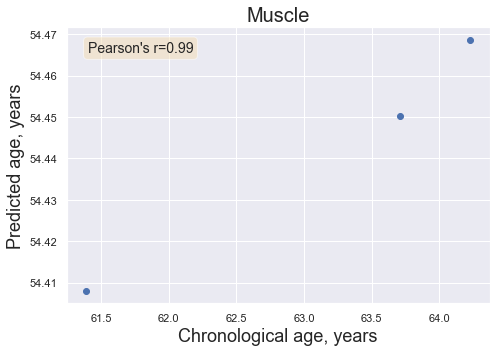

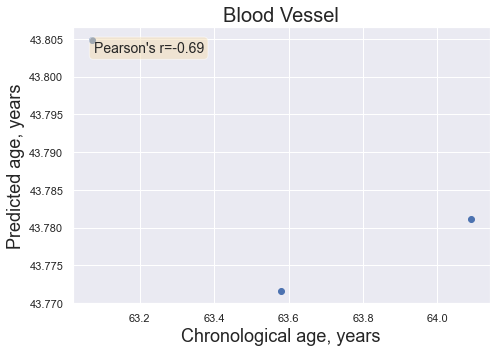

In [207]:
from sklearn.preprocessing import StandardScaler

# This section checks for the MLP training on the whole data, with attempting to learn one data point
from pandas import DataFrame as df
genes_clock = {}
score = {}
pearson_corr = {}
prediction = {}
true = {}

newAges = {}
tissue_num = 2 if runmode != "prod" else len(tissues)

for i, tissue in enumerate(tissues[:tissue_num]):
    scalerX = StandardScaler().fit(data[tissue].T)
    scalery = StandardScaler().fit(np.array(age[tissue]).reshape(-1, 1))
    data_norm = scalerX.transform(data[tissue].T).T
    ages_norm = scalery.transform(np.array(age[tissue]).reshape(-1, 1))

    newAges[tissue] = ages_normalized[tissue]

    points = 10 if runmode != "prod" else data_normalized[tissue].shape[1]
    assert(points <= data_normalized[tissue].shape[1]) # 803 max
    
    # This transpose: data_normalized[tissue].T.iloc[:points].T is so we can take the first points rows
    score[tissue], pearson_corr[tissue], true[tissue], prediction[tissue] = \
    fit_mlp_model(data_normalized[tissue].T.iloc[:points].T, ages_normalized[tissue][:points], tissue, scalery, True) # tunes
    # fit_mlp_model(data_normalized[tissue].T.iloc[:points].T, age[tissue][:points], tissue, False, 0, 1000, 1e-2) # doesnt tune
#mlpregressor
#mlp classifier - 3.75

In [ ]:
#Save results

import pickle

model_type = "blood_vessel_tune_only" # only hp tuned on blood vessels

# store
with open('saved_variables/score_' + model_type + '.pickle', 'wb') as handle:
    pickle.dump(score, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('saved_variables/pearson_corr_' + model_type + '.pickle', 'wb') as handle:
    pickle.dump(pearson_corr, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('saved_variables/true_' + model_type + '.pickle', 'wb') as handle:
    pickle.dump(true, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('saved_variables/prediction_' + model_type + '.pickle', 'wb') as handle:
    pickle.dump(prediction, handle, protocol=pickle.HIGHEST_PROTOCOL)

#load
# with open('score.pickle', 'wb') as handle:
#     score = pickle.load(handle)
# with open('pearson_corr.pickle', 'wb') as handle:
#     pearson_corr = pickle.load(handle)
# with open('true.pickle', 'wb') as handle:
#     true = pickle.load(handle)
# with open('prediction.pickle', 'wb') as handle:
#     prediction = pickle.load(handle)

# Additional analysis

### Comparing prediction accuracy for different tissues

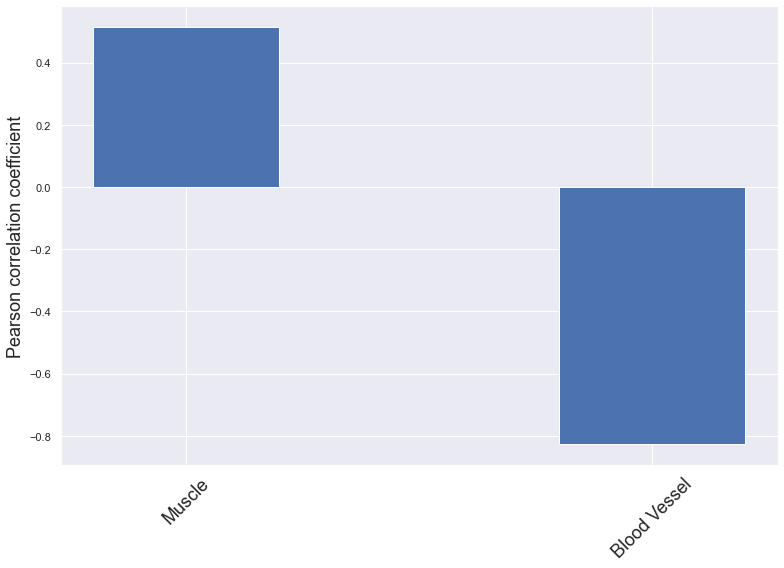

In [154]:
fig, ax = plt.subplots(figsize=(11,8))
n=2
x_coords = np.arange(0,n*len(tissues), n)
ax.set_xticks(np.arange(0,n*len(tissues), n))
coeff = np.asarray([pearson_corr[tissue][0] for tissue in tissues])
ax.set_xticklabels([tissues[i] for i in np.argsort(coeff)[::-1]], rotation=45, fontsize=xlabel_fontsize)
ax.bar(x_coords, coeff[np.argsort(coeff)[::-1]], \
    color='C0', edgecolor='white')
ax.set_ylabel('Pearson correlation coefficient', fontsize=ylabel_fontsize) 
plt.tight_layout()
pp = "/Users/elvirakinzina/src/Aging_clock/Pictures/Number_of_genes_and_correlation." + figure_format
# plt.savefig(pp, format = figure_format)

## Define most important covariates
These could be included in the model or regressed out to improve age prediction

In [ ]:
def gaussian_project(data, standardize=True, noise=1e-6):
    """ Project each row onto gaussian with matched mean, stdev 

    standardize : bool
        project each row onto N(0, 1), otherwise use N(mu_row, sigma_row),
        where mu_row is the mean of the row and sigma_row is the standard
        deviation
    noise : float
        add random noise drawn from interval (0, noise) to break ties
    """
    # add random noise to break ties
    err = np.random.random(data.shape) * noise
    data = data + err

    ppt = data.rank(axis=1) / (float(data.shape[1])+1.)
    if standardize:
        df = pd.DataFrame(ss.norm.ppf(ppt), index=ppt.index, 
                          columns=ppt.columns)
    else:
        mu = data.mean(axis=1)
        sigma = data.std(axis=1)
        df = {}
        for r in ppt.index:
            df[r] = pd.Series(ss.norm.ppf(ppt.loc[r], loc=mu.loc[r],
                                          scale=sigma.loc[r]), index=ppt.columns)
        df = pd.DataFrame(df).T
    return df
def find_covars_corr_with_first_2_pcs(tissue, data, ax):
        dt = data.copy()
        dt_g = gaussian_project(dt)

        assert(np.sort(np.std(dt_g))[0] > 0)
        print(dt_g.shape)
        assert(dt_g.equals(dt_g.replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()))
        u, s, vh = np.linalg.svd(dt_g)
        # print(s)
        # print(np.sort(s))
        # pca = PCA().fit(dt_g)
        # u, s, vh = np.linalg.svd(dt_g[:-1, :])
        # # print(s)
        # print(np.sort(s))
        pca = PCA().fit(dt_g)

        # extract principal components
        comps = pd.DataFrame(pca.components_.T, index=dt_g.columns,
                             columns=['PC%i' % (i+1) for i in range(len(pca.components_))])
        
        # choose potential important covariates (add whatever you are interesred in)
        covars = ['SMRIN', 'SMTSISCH', 'TRISCHD', 'ETHNCTY', 'RACE', 'AGE', 'BMI', 'SMNTRNRT', 'DTHRFG', 'DTHVNT', \
                  'SMATSSCR', 'SMALTALG', 'DTHHRDY', 'DTHHRDY']
        print('components', pca.explained_variance_ratio_[0:10])
    
        if np.fabs(sum(pca.explained_variance_ratio_)-1)>0.1:
            print('sum', sum(pca.explained_variance_ratio_))
        
        covs_r = {}
        covs_p = {}
        for pc in ['PC{}'.format(i+1) for i in range(10)]:
            _r = {}
            _p = {}
            for cv in covars:
                if cv in sampleMetaData.columns:
                    covar_vals = np.asarray(sampleMetaData.loc[comps.index, cv])
                elif cv in subjectMetaData.columns:
                    sample_subject_ids = [index.split("-")[0] + "-" + index.split("-")[1] \
                                 for index in list(comps.index)]
                    covar_vals = np.asarray(subjectMetaData.loc[sample_subject_ids, cv])
                _r[cv], _p[cv] = ss.pearsonr(covar_vals[np.isfinite(covar_vals)], \
                                             comps.loc[np.isfinite(covar_vals), pc])
                covs_r[pc] = pd.Series(_r)
                covs_p[pc] = pd.Series(_p)
        covs_r = pd.DataFrame(covs_r).loc[:, ['PC{}'.format(i+1) for i in range(10)]]
        covs_p = pd.DataFrame(covs_p).loc[:, ['PC{}'.format(i+1) for i in range(10)]]

        covarsMain = [covar for covar in covars if (covs_p.loc[covar,:][0:10]<0.05).any()==True]
        first_2_pcs_pars = [covar for covar in covars if (covs_p.loc[covar,:][0:2]<0.05).any()==True]
        ax.set_title(tissue)
        sns.heatmap(-1*np.log10(covs_p.loc[covarsMain,:]), ax=ax, vmax=10, annot=True, fmt=".1f")
        return(first_2_pcs_pars)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
first_2_pcs_pars = find_covars_corr_with_first_2_pcs('Muscle', data['Muscle'], ax)  

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
first_2_pcs_pars = find_covars_corr_with_first_2_pcs('Esophagus', data['Esophagus'], ax)

## Color PCA by parameter (age, RNA quality, ischemic time before) values to explore important parameters for each tissue

You can look at other technical or phenotypic covariates to find those that can possibly explain PCA patterns for tissues that clearly have clusters: skin and esophagus

In [ ]:
def plot_pca_colored_by(data, parameter):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    pca = decomposition.PCA(n_components=2)
    X = data.transpose().copy()
    pca.fit(X)
    y = np.asarray(parameter)
    X = pca.transform(X)
    y_no_na = y[np.where(np.isfinite(y))]
    y_min = np.min(y_no_na)
    y_max = np.max(y_no_na)
    
    for i in range(len(X[:, 0])):
        if np.isfinite(y[i]):
            alpha = float((y[i]-y_min)/float(y_max-y_min))
            ax.scatter(X[i, 0], X[i, 1], color = 'green', alpha = alpha, s=15)

In [ ]:
plot_pca_colored_by(residual_no_outliers["Esophagus"], SMTSISCH["Esophagus"])

## Sample size of each tissue
I chose top 8 tissues for the analysis above

In [ ]:
# tissues = list(set(sampleMetaData['SMTS']))
# sample_num = dict()
# for tissue in tissues:
#         data[tissue], age[tissue], SMRIN[tissue], SMTSISCH[tissue] = load_data(tissue)
#         sample_num[tissue] = data[tissue].shape[1]
# out_file = "/om2/user/elvira/src/data/GTEx_v8/rna_seq/Tissues_sample_numbers.pkl"
# with open(out_file, "wb") as f:
#     pickle.dump(sample_num,f,pickle.HIGHEST_PROTOCOL)

In [ ]:
sample_num = pd.read_pickle("/om2/user/elvira/src/data/GTEx_v8/rna_seq/Tissues_sample_numbers.pkl")
tissues = list(sample_num.keys())
sample_numbers = np.asarray([sample_num[tissue] for tissue in tissues])
indices = np.argsort(sample_numbers)[::-1]
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.bar(range(len(tissues)), sample_numbers[indices])
ax.set_xticks(range(len(tissues)))
ax.set_xticklabels([tissues[index] for index in indices], rotation = 90)

## Plot sample age distribution for each tissue
Most samples are from elderly since they die more often

In [ ]:
for tissue in tissues:
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.hist(age[tissue])
    ax.set_title(tissue, fontsize=title_fontsize)